# GANs - Generative Adverserial Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### MNIST data

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, y_train.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

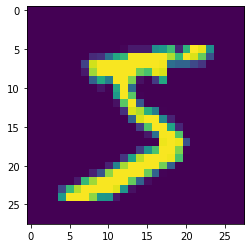

In [4]:
plt.imshow(X_train[0])

### Reshape & Rescale les Images pour DCGAN

Le générateur utilisera la fonction d'activation de tanh pour la dernière couche, nous voulons donc remodeler X_train pour qu'il soit dans les limites de -1 à 1.

In [5]:
# Normalization
X_train = X_train  / 255.0
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

X_train.min(), X_train.max()

(-1.0, 1.0)

#### Filtrer les données pour un entraînement plus rapide sur un plus petit ensemble de données

In [6]:
only_zeros = X_train[y_train == 0]
only_zeros.shape

(5923, 28, 28, 1)

### Generator


In [21]:
codings_size = 100

In [7]:
generator = Sequential()

generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"))

### Disciminator

In [8]:
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3), input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [9]:
GAN = Sequential([generator, discriminator])

In [10]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [11]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [12]:
GAN.layers

In [13]:
# Generator
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

In [15]:
# discriminator
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 0
Non-trainable params: 212,865
________________________________________________

### Mise en place des batches d'entraînement

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

Le paramètre buffer_size dans Dataset.shuffle() peut affecter le caractère aléatoire de votre ensemble de données, et donc l'ordre dans lequel les éléments sont produits. 

In [29]:
batch_size, epochs = 32, 50

In [17]:
# my_data = X_train
my_data = only_zeros

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [19]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

**NOTE : Le générateur ne voit jamais d'images réelles. Il apprend en regardant les gradients qui remontent à travers le discriminateur. Plus le discriminateur s'améliore au cours de l'entraînement, plus il contient d'informations dans ses gradients, ce qui signifie que le générateur peut être amené à progresser dans l'apprentissage de la génération de fausses images, dans notre cas, de faux zéros.**

## Boucle d'Entraînement

In [ ]:
# Saisir les composants séparés
generator, discriminator = GAN.layers

# Pour chaque epoch
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # Pour chaque batch dans le dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #########################################
        ## ENTRAINEMENT DU DISCRIMINATEUR ######
        #######################################
        
        # Créer du bruit
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Générer des chiffres basés uniquement sur du bruit d'entrée
        gen_images = generator(noise)
        
        # Concaténer les images générées contre les images réelles
        # POUR utiliser tf.concat, les types de données doivent correspondre !
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Cibles fixées à zéro pour les fausses images et à 1 pour les images réelles
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # Cela permet de se débarrasser d'un avertissement Keras
        discriminator.trainable = True
        
        # Entraîner le discriminateur sur ce batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## ENTRAINEMENT DU GÉNÉRATEUR ######
        ###################################
        
        # Créer un peu de bruit
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Nous voulons que les discriminateurs croient que les fausses images sont réelles
        y2 = tf.constant([[1.]] * batch_size)
        
        # Éviter un avertissement
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Il est fort probable que votre générateur n'apprenne à créer qu'un seul type de bruit zéro. Quel que soit le bruit qui y passe.

https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same

In [31]:
noise = tf.random.normal(shape=[10, codings_size])

noise.shape

TensorShape([10, 100])

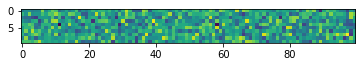

In [32]:
plt.imshow(noise)

In [33]:
images = generator(noise)

In [34]:
single_image = images[0]

In [35]:
# single_image.numpy().reshape(28,28)

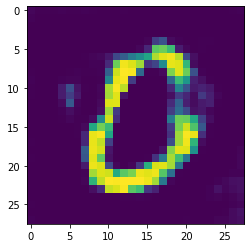

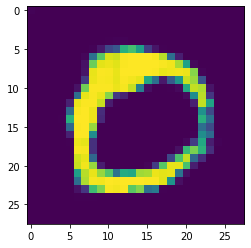

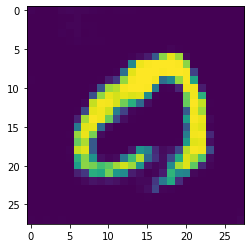

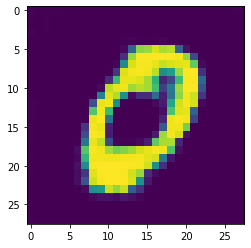

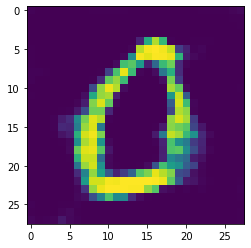

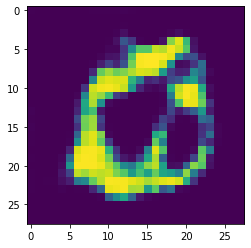

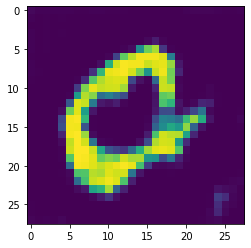

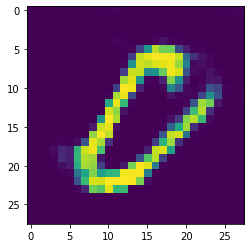

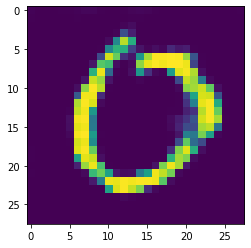

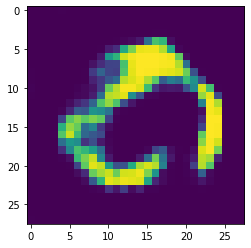

In [36]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()

**Visionnez notre vidéo de conclusion pour connaître les meilleures pratiques dans ce domaine ! Nous avons besoin de GPUs très puissants pour obtenir des résultats réalistes !**